<h1>Getting the CIFAR-10 dataset</h1>
In this notebook we will mainly use the well-known CIFAR-10 dataset which can be download from https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

In [71]:
import struct
import os
import sys
import numpy as np
import hashlib
import tarfile
import random
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from timeit import default_timer as timer
%matplotlib inline

Use old download helper function from previous notebook

In [72]:
# Download utility function
def downloadProgressCallBack(blocknum, blocksize, totalsize):
    readsofar = blocknum * blocksize
    if totalsize > 0:
        percent = readsofar * 1e2 / totalsize
        s = "\r%5.1f%% %*d / %d" % (
            percent, len(str(totalsize)), readsofar, totalsize)
        sys.stderr.write(s)
        if readsofar >= totalsize: # near the end
            sys.stderr.write("\n")
    else: # total size is unknown
        sys.stderr.write("read %d\n" % (readsofar,))

# File integrety checker
def md5Checksum(filename):
    md5 = hashlib.md5()
    with open(filename,'rb') as f: 
        for chunk in iter(lambda: f.read(8192), b''): 
            md5.update(chunk)
    return md5.hexdigest()

Download and extract .tar.gz archive

In [73]:
baseCIFARurl="https://www.cs.toronto.edu/~kriz/"
cifarDatasetFileNames = ["cifar-10-python.tar.gz"]
cifarMD5sum = ["c58f30108f718f92721af3b95e74349a"]
extractedPath = "."

for fileNo in range(0,len(cifarDatasetFileNames)):
    if os.path.exists(cifarDatasetFileNames[fileNo]) and md5Checksum(cifarDatasetFileNames[fileNo]) == cifarMD5sum[fileNo]:
        print(cifarDatasetFileNames[fileNo] + ' is already exist and md5sum is match')
    else:
        print('Downloading '+cifarDatasetFileNames[fileNo])
        urlretrieve(baseCIFARurl+cifarDatasetFileNames[fileNo],cifarDatasetFileNames[fileNo], downloadProgressCallBack)
        
    # Decompress .tar.gz 
    print("Extracting dataset")
    tarfile.open(name=cifarDatasetFileNames[fileNo], mode="r:gz").extractall(extractedPath)
    print("Finish!")

cifar-10-python.tar.gz is already exist and md5sum is match
Extracting dataset
Finish!


# Dataset exploring
Now, CIFAR-10 dataset is extracted into "cifar-10-batches-py" directory. This dataset in its original form is divided into 5 training batches and one test batch, each with 10000 images in data_batch_1 to data_batch_5 files . The test batch contains exactly 1000 randomly drawn images from each class.

We will use unpickle function provided by the dataset owners to extract and explore 

In [91]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

The output from unpickle function is a dict with the following keys:

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

However, after explore the output dict keys, we need to append 'b' in front of the original key to propely gather the data!

In [98]:
# For simplicity in training process, merge five training batches into 1 numpy array
trainingDatasetBaseFileName = "cifar-10-batches-py/data_batch_"
trainingImages = np.empty((0,32,32,3),dtype=np.uint8)
trainingLabels = np.empty((0,),dtype=np.uint8)

for trainingBatchNo in range(1,6):
    outputDict = unpickle(trainingDatasetBaseFileName + str(trainingBatchNo))
    print('Image data in',trainingDatasetBaseFileName + str(trainingBatchNo),' dimension',outputDict[b'data'].shape)
    # Stack in row-wise order
    data = outputDict[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    print(data.shape)
    trainingImages = np.concatenate((trainingImages,data),axis=0)
    # Since the label is in list format, convert them into row-wise numpy array
    trainingLabels = np.hstack((trainingLabels,np.array(outputDict[b'labels'])))
print('Training data dimension',trainingImages.shape)
print('Training label dimension',trainingLabels.shape)

Image data in cifar-10-batches-py/data_batch_1  dimension (10000, 3072)
(10000, 32, 32, 3)
Image data in cifar-10-batches-py/data_batch_2  dimension (10000, 3072)
(10000, 32, 32, 3)
Image data in cifar-10-batches-py/data_batch_3  dimension (10000, 3072)
(10000, 32, 32, 3)
Image data in cifar-10-batches-py/data_batch_4  dimension (10000, 3072)
(10000, 32, 32, 3)
Image data in cifar-10-batches-py/data_batch_5  dimension (10000, 3072)
(10000, 32, 32, 3)
Training data dimension (50000, 32, 32, 3)
Training label dimension (50000,)


In [100]:
# Test data
testDataDict = unpickle("cifar-10-batches-py/test_batch")
testImages = testDataDict[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
testLabels = np.array(testDataDict[b'labels'])
print('Test data dimension',testImages.shape)
print('Test label dimension',testLabels.shape)

Test data dimension (10000, 32, 32, 3)
Test label dimension (10000,)


In [101]:
# Save our organize dataset form into single npz file
np.savez('cifar-10.npz', trainingImages=trainingImages, trainingLabels=trainingLabels,testImages=testImages,testLabels=testLabels)
# Delete all variables and load from file insted
del outputDict,trainingImages,trainingLabels,testImages,testLabels,testDataDict

In [102]:
# Load our dataset from file
loadNPZ = np.load('cifar-10.npz')
trainingImages = loadNPZ['trainingImages']
trainingLabels = loadNPZ['trainingLabels']
testImages = loadNPZ['testImages']
testLabels = loadNPZ['testLabels']
print("Training Images Dimension:",trainingImages.shape)
print("Training Labels Dimension:",trainingLabels.shape)
print("Test Images Dimension:",testImages.shape)
print("Test Labels Dimenstion:",testLabels.shape)

Training Images Dimension: (50000, 32, 32, 3)
Training Labels Dimension: (50000,)
Test Images Dimension: (10000, 32, 32, 3)
Test Labels Dimenstion: (10000,)


In [126]:
# Define label dict
labelDict = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

Randomy shown training and testing images their actual label

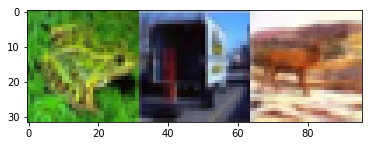

Class Label: 6 9 4
Class Label: frog truck deer


In [131]:
randomIdx = random.sample(range(trainingImages.shape[0]),3)
randomImage = trainingImages[randomIdx,:,:,:]
concatRandomImage = np.concatenate((randomImage[0,:,:,:],randomImage[1,:,:,:],randomImage[2,:,:,:]),axis=1)
plt.figure()
plt.imshow(concatRandomImage)
plt.show()
print('Class Label:',trainingLabels[randomIdx[0]],trainingLabels[randomIdx[1]],trainingLabels[randomIdx[2]])
print('Class Label:',labelDict[trainingLabels[randomIdx[0]]],
      labelDict[trainingLabels[randomIdx[1]]],labelDict[trainingLabels[randomIdx[2]]])

In [154]:
# Reshape data into RGB pixel-wise row vector and convert into float32 to prevent calculation overflow
prepTrainingImages = trainingImages.reshape(trainingImages.shape[0],3072).astype(np.float32)
prepTestImages = testImages.reshape(testImages.shape[0],3072).astype(np.float32)
print('Prepare Training Images Dimension:',prepTrainingImages.shape)
print('Prepare Test Images Dimension:',prepTestImages.shape)

Prepare Training Images Dimension: (50000, 3072)
Prepare Test Images Dimension: (10000, 3072)


In [160]:
# Create one-hot encoded vector for both training and test target output vector
prepTrainingLabels = np.zeros((trainingLabels.size, trainingLabels.max()+1)).astype(np.float32)
prepTrainingLabels[np.arange(trainingLabels.shape[0]), trainingLabels] = 1
prepTestLabels = np.zeros((testLabels.size, testLabels.max()+1)).astype(np.float32)
prepTestLabels[np.arange(testLabels.shape[0]), testLabels] = 1
print('Prepare Training Label Dimension:',prepTrainingLabels.shape)
print('Prepare Test Label Dimension:',prepTestLabels.shape)

Prepare Training Label Dimension: (50000, 10)
Prepare Test Label Dimension: (10000, 10)


Now, we already prepare data and label for training/test in row vector form, Let's begin your own neural network implementation by using the following program skeleton
Remark : This is just a minimal skeleton. YOU CAN IMPLEMENT YOUR OWN FUNCTIONS, MODIFY FUNCTION PARAMS OR ANYTHING YOU CAN IMAGINE TO GET IT WORK!!

In [156]:
class neuralNetwork(object):
    def __init__(self, input, hidden, output, iterations, learning_rate):
        """
        input : size of input neurons (number of feature)
        hidden: number of hidden neurons (how many hidden node?)
        output: number of output neurons (number of output class)
        """
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.verbose = verbose # For debugging
        self.output_activation = output_layer
        self.input = input 
        self.hidden = hidden
        self.output = output
        
        # Weight matrix randomization
        # Tips : https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.rand.html
    def feedForward(self, inputs):
        ''' 
        Run through all the nodes in the network from input layer to output layers by 
        calculate the outputs from the input layer multiply with their corresponded weights
        Don't forget that you have to applied the chosen activate function to the multiplication result before
        passed to the next layer.
        inputs: input data
        return: output vector
        '''
        
        # Hidden layer , gather the input vector, multiply by corresponded weight, sum the result and 
        # apply chosen activate function
        
        
        
        # Output layer
        
        
        return 
    
    def backProp(self, targets):
        ''' 
        For the output layer
        - Calculates the diff between output and target vector
        - Calculate the derivative of the sigmoid function to determine how much the weights need to change
        - Update the layer weights based on the learning rate and sigmoid grad
        For the hidden layer
        - Calculate the sum of the strength of each output link multiplied by how much the target node has to change
        - Calculate the derivative of the sigmoid function to determine how much the weights need to change
        - Update the weights based on learning rate and derivative
        targets: actual output vector
        N: learning rate
        return: updated weight matrix
        '''
        # calculate error and gradient direction based on actual output vector
        # the delta (theta) tell you which direction to change the weights
        
        
        # calculate error and gradient direction for hidden layer
        
        
        # update the weights connecting hidden -> output
        

        # update the weights connecting input -> hidden


        # calculate error

        
        return ?
    
     def predict(self, input):
        # For single instance prediction
        if(input.shape(0) == 1):
            print('Output Layer Result:',self.feedForward(input))

    def test(self,inputs,labels):
        # Apply feedForward and compare the result to actual label
        
    def train(self, inputs,labels,test_inputs,test_labels):
        for iteration in range(self.iterations):
            # To ensure that the each iteration is not order correlated, you should apply data shuffling first
            
            # Feedforward
            
            # Backprop to update weight
            
            # Calculate accuray on test dataset at every X iteration and print the result
            
            # You may plot accuray and grad_error as graph to  ensure that you are working in right direction
            
            # You should decay your learning rate over the period of the training based on some criterions, such as
            # halves at every X iterations
            
            

SyntaxError: unexpected EOF while parsing (<ipython-input-156-21d922c9be53>, line 2)

In [ ]:
# Call your created NN
ann = neuralNetwork(64, 100, 10, iterations = , learning_rate = )
ann.train(prepTrainingImages,prepTrainingLabels,prepTestImages,prepTestLabels)

In [ ]:
# Plot the confusion matrix